In [1]:
from datetime import date, timedelta, datetime
from pyspark.sql.functions import collect_list, substring
from pyspark.sql import Row
import pandas as pd
import numpy as np
import ujson as json
import os.path
from collections import Counter
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def int2date(n):
    """
    This function converts a number of days since Jan 1st 1970 <n> to a date.
    """
    try:
        return date(1970,1,1)+timedelta(days=n)
    except:
        return date(1970,1,1)

def date2int(d):
    """
    This function converts a date <d> to number of days since Jan 1st 1970.
    """
    try:
        return (d-date(1970,1,1)).days
    except:
        return -1

def str2date(s, f="%Y%m%d"):
    """
    This function converts a string <s> in the format <f> to a date.
    """
    try:
        return datetime.strptime(s, f).date()
    except:
        return ""

TODAY = date.today()                                    # today (date)
TODAY_INT = date2int(TODAY)                             # today (days since Jan 1st, 1970)
PCD_CUTOUT_START_DATE = date(2010, 1, 1)                # profiles created before this date are removed (date)
PCD_CUTOUT_START_INT = date2int(PCD_CUTOUT_START_DATE)  # profiles created before this date are removed (days since Jan 1st, 1970)

D0 = date(2016, 9, 15)                                  # date of of analysis (date)
D0_INT = date2int(D0)                                   # date of analysis (days since Jan 1st, 1970)

T0 = 30                                                 # days of latency
D0_T0 = D0 - timedelta(days=T0)                         # date beginning of latency period (date)
D0_T0_INT = D0_INT - T0                                 # date beginning of latency period (days since Jan 1st, 1970)

T1 = 90                                                 # days to come back
D0_T1 = D0 + timedelta(days=T1)                         # date beginning of come back period (date)
D0_T1_INT = D0_INT + T1                                 # date beginning of come back period (days since Jan 1st, 1970)

# First, let's get data from main_summary and some counts

In [3]:
allPingsDF = sqlContext.read.load("s3://telemetry-parquet/main_summary/v3", "parquet", mergeSchema=True)
    
# perform variable selection with column renaming
allPingsDFSelect = allPingsDF.select(
           allPingsDF.client_id.alias("cid"),
           allPingsDF.subsession_start_date.alias("ssd"),
           allPingsDF.sample_id.alias("sid"),
           allPingsDF.normalized_channel.alias("channel"),
           allPingsDF.app_name.alias("appname"),
           allPingsDF.subsession_length.alias("ssl"),
           allPingsDF.profile_creation_date.alias("pcd")
)

# - 1% sample (sample_id is 42)
# - channel is release
# - application is Firefox
# - subsession length is positive and less than 24h
# - profile creation date is after Jan 1st, 2010 and before TODAY
filteredPingsDF = allPingsDFSelect.filter(allPingsDFSelect.sid == "42")\
                                  .filter(allPingsDFSelect.channel == "release")\
                                  .filter(allPingsDFSelect.appname == "Firefox")\
                                  .filter(allPingsDFSelect.ssl >= 0)\
                                  .filter(allPingsDFSelect.ssl <= 86400)\
                                  .filter(allPingsDFSelect.pcd >= PCD_CUTOUT_START_INT)\
                                  .filter(allPingsDFSelect.pcd <= TODAY_INT)\
                                  .select(["cid",
                                           substring("ssd", 0, 10).alias("ssd")
                                          ])\
                                  .cache()

filteredPingsDF_str = "filteredPingsDF"
sqlContext.registerDataFrameAsTable(filteredPingsDF, filteredPingsDF_str)

In [4]:
print "{:,} total pings".format(filteredPingsDF.count()) # ~1.3B pings

1,276,916,123 total pings


In [5]:
filteredPingsDF.take(10)

[Row(cid=u'f2477312-822f-4ff2-bc64-da937cfa65c0', ssd=u'2017-01-11'),
 Row(cid=u'36a7f893-acbe-4e3f-a143-22072e29003a', ssd=u'2017-01-11'),
 Row(cid=u'16c632e6-4894-420f-a36e-959becfe1e0a', ssd=u'2017-01-11'),
 Row(cid=u'bbe11592-0a14-7a44-9378-6da30333c44d', ssd=u'2017-01-12'),
 Row(cid=u'317519e0-a235-48ac-8a3c-da7c97bc739e', ssd=u'2017-01-11'),
 Row(cid=u'65711634-f4b2-466a-aeb2-7c11b8d0609f', ssd=u'2017-01-11'),
 Row(cid=u'317519e0-a235-48ac-8a3c-da7c97bc739e', ssd=u'2017-01-11'),
 Row(cid=u'208d975e-87dc-4744-adaa-54f0bbb4e4db', ssd=u'2017-01-11'),
 Row(cid=u'b3ef7ee1-2767-4d9e-9137-e9937fa3be9b', ssd=u'2017-01-11'),
 Row(cid=u'1dee170b-7978-4c85-81b2-d8718d6acb69', ssd=u'2017-01-11')]

In [6]:
print "{:,} total users".format(filteredPingsDF.groupBy("cid").count().count()*100) # ~830M users

827,652,700 total users


# Now let's aggregate the data by client_id and date for users who were active on D0

In [7]:
def get_active_on_date(DF_str, date_str):
    """
    This function creates and returns a table that is aggregated by client_id (cid) and subsession_start_date (ssd).
    Only client_ids that were active on given date are kept.
    For each tuple (cid, sd), the number of subsessions per day is aggregated.
    NOTE: This could be changed. For example, we may not need to know that a user was active multiple times per day.
    
    @params:
        DF_str: [string] name of the dataframe returned by aggregate_by_client_date(...)
        date_str: [string] date for analysis
    """
    
    query = """
    SELECT cid,
           ssd,
           count(*) as num_ssd
    FROM {table}
    WHERE cid IN
    (
        SELECT distinct cid
        FROM {table}
        WHERE ssd = '{date}'
    )
    GROUP BY cid, ssd
    """.format(table=DF_str,
               date=date_str)
    
    active = spark.sql(query).cache()
    
    return active

In [8]:
activeDF = get_active_on_date(filteredPingsDF_str, D0.isoformat())
activeDF_str = "activeDF"
sqlContext.registerDataFrameAsTable(activeDF, activeDF_str)

In [9]:
activeDF.take(10)

[Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-12-02', num_ssd=4),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-12-01', num_ssd=5),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-08-03', num_ssd=13),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-08-02', num_ssd=13),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-05-18', num_ssd=12),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-05-23', num_ssd=8),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2017-03-07', num_ssd=9),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2017-03-06', num_ssd=8),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-11-07', num_ssd=2),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-11-08', num_ssd=3)]

In [10]:
dau = activeDF.select("cid").distinct().count()*100
print "DAU for {}: {:,}".format(D0.isoformat(), dau) # ~110M users

DAU for 2016-09-15: 114,621,800


# Now let's group by client_id and have a list of activity dates

In [11]:
# Make a longitudinal data frame where each row has:
# - client id
# - list of subsession_start_date
# - list of number of times profile was active that day (same index for both lists)
longitudinal = activeDF.groupBy("cid")\
                       .agg({"ssd": "collect_list",
                             "num_ssd": "collect_list"})\
                       .withColumnRenamed("collect_list(ssd)","ssd")\
                       .withColumnRenamed("collect_list(num_ssd)", "num_ssd")

In [12]:
t=longitudinal.take(1)[0]
print "One client id: {}".format(t.cid)
print "First five ssd for this client id (unordered): {}".format(t.ssd[:5])
print "First five num_ssd for this c_id  (unordered): {}".format(t.num_ssd[:5])

One client id: 00018e0c-b07f-4097-89cb-5910a95002f2
First five ssd for this client id (unordered): [u'2016-12-02', u'2016-12-01', u'2016-08-03', u'2016-08-02', u'2016-05-18']
First five num_ssd for this c_id  (unordered): [4, 5, 13, 13, 12]


In [13]:
# Let's verify that it works
# Everything seems OK!
query = """
SELECT cid,
       ssd,
       count(*) as num_ssd
FROM {table}
WHERE cid = '00018e0c-b07f-4097-89cb-5910a95002f2'
AND ssd IN ('2016-04-20', '2016-04-21', '2016-09-03', '2016-04-10', '2016-04-09')
GROUP BY cid, ssd
""".format(table=filteredPingsDF_str)

spark.sql(query).collect()

[Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-09-03', num_ssd=18),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-04-20', num_ssd=13),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-04-09', num_ssd=6),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-04-21', num_ssd=9),
 Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', ssd=u'2016-04-10', num_ssd=6)]

# Let's figure out the time since last activity (tsla) and time until next activity (tuna) for each user

In [14]:
def mapping(row):
    """
    Applied to an RDD, this mapping function returns a tuple of 5 elements:
        - cid
        - ssd (sorted ascending through time)
        - num_ssd (sorted according to ssd)
        - tsla (time since last activity in days)
        - tuna (time until next activity in days)
    
    @params:
        row: [Row] a row from a longitudinal RDD that includes:
            - cid: client_id
            - ssd: subsession_start_date
    
    @logic:
        - sort the row based on ssd (ascending).
        - if there was activity prior to D0, get tsla
        - if there was activity after D0, get tuna
            - if not, those are set to -1
            - in case of badly formatted ssd, return -2
    """
    
    def sort_row(row):
        # sort ssd by ascending ssd
        zipped = sorted(zip(row.ssd, row.num_ssd), reverse=False)
        ssd, num_ssd = zip(*zipped)
        
        # return reformatted Row
        return Row(cid=row.cid,
                   ssd=list(ssd),
                   num_ssd=list(num_ssd)
                  )
    
    tsla = -1                        # time since last activity (days)
    tuna = -1                        # time until next activity (days)
    
    sorted_row = sort_row(row)      # sorted row
    
    # find index of D0
    index_D0 = sorted_row.ssd.index(D0.isoformat())
    indices_before_D0 = range(index_D0)
    indices_after_D0 = range(index_D0+1, len(sorted_row.ssd))
    
    # there was activity prior to D0
    if len(indices_before_D0) > 0:
        try:
            last_activity_date = sorted_row.ssd[indices_before_D0[-1]]
            tsla = (D0 - datetime.strptime(last_activity_date, '%Y-%m-%d').date()).days
        except:
            # error in date format
            tsla = -2
    # maybe else check if num_ssd > 1 (active on same day), then tsla = 0?
    
    # there was activity after D0
    if len(indices_after_D0) > 0:
        try:
            next_activity_date = sorted_row.ssd[indices_after_D0[0]]
            tuna = (datetime.strptime(next_activity_date, '%Y-%m-%d').date() - D0).days
        except:
            # error in date format
            tuna = -2
    # maybe else check if num_ssd > 1 (active on same day), then tuna = 0?

    return (sorted_row.cid,              # cid
            sorted_row.ssd,              # list of ssd (ascending)
            sorted_row.num_ssd,          # list of num_ssd (based on ssd)
            tsla,                        # time since last activity (days)
            tuna,                        # time until next activity (days)
           )

In [15]:
mapped = longitudinal.rdd.map(mapping)

In [16]:
# mapped.first()

# Before answering the questions, let's first see some counts of users who were not active before D0, after D0, or both

In [17]:
# Reminder of DAU
print "DAU for {}: {:,}".format(D0.isoformat(), dau)

DAU for 2016-09-15: 114,621,800


In [18]:
# Negative tsla <=> not active before D0
tsla_neg = mapped.filter(lambda row: row[3] < 0)
# tsla_neg_DF = tsla_neg.toDF(["cid","ssd","num_ssd","tsla","tuna"])
# tsla_neg_pd = tsla_neg_DF.toPandas()

In [19]:
tsla_neg_cnt = tsla_neg.count()*100
print "{:,} users have no activity before {} ({:.2%} of DAU)"\
      .format(tsla_neg_cnt, D0.isoformat(), tsla_neg_cnt*1./dau)

1,903,200 users have no activity before 2016-09-15 (1.66% of DAU)


In [20]:
# Negative tuna <=> not active after D0
tuna_neg = mapped.filter(lambda row: row[4] < 0)
# tuna_neg_DF = tuna_neg.toDF(["cid","ssd","num_ssd","tsla","tuna"])
# tuna_neg_pd = tuna_neg_DF.toPandas()

In [21]:
tuna_neg_cnt = tuna_neg.count()*100
print "{:,} users have no activity after {} ({:.2%} of DAU)"\
      .format(tuna_neg_cnt, D0.isoformat(), tuna_neg_cnt*1./dau)

1,868,000 users have no activity after 2016-09-15 (1.63% of DAU)


In [22]:
# Negative tsla and tuna <=> only active on D0
tsla_tuna_neg = mapped.filter(lambda row: (row[3] < 0 and row[4] < 0))
# tsla_tuna_neg_DF = tsla_tuna_neg.toDF(["cid","ssd","num_ssd","tsla","tuna"])
# tsla_tuna_neg_pd = tsla_tuna_neg_DF.toPandas()

In [23]:
tsla_tuna_neg_cnt = tsla_tuna_neg.count()*100
print "{:,} users were only active on {} ({:.2%} of DAU)"\
      .format(tsla_tuna_neg_cnt, D0.isoformat(), tsla_tuna_neg_cnt*1./dau)

824,400 users were only active on 2016-09-15 (0.72% of DAU)


In [24]:
# One row has a badly formatted date at some point
# We can disregard it (or implement some better error checking at some point)
bad_dates = mapped.filter(lambda row: (row[3] == -2 or row[4] == -2))
# bad_dates_df = bad_dates.toDF(["cid","ssd","num_ssd","tsla","tuna"])
# bad_dates_pd = bad_dates_df.toPandas()

In [25]:
bad_dates_cnt = bad_dates.count()*100
print "{:,} users have a bad date format somewhere ({:.2%} of DAU)"\
      .format(bad_dates_cnt, bad_dates_cnt*1./dau)

100 users have a bad date format somewhere (0.00% of DAU)


# Now let's answer the questions

## tsla > 30 <=> last time user was active was more than 30 days before D0

In [26]:
# tsla > 30 <=> last time user was active was more than T0 (30) days before D0
tsla_30 = mapped.filter(lambda row: row[3] > T0)
tsla_30_DF = tsla_30.toDF(["cid","ssd","num_ssd","tsla","tuna"])
tsla_30_pd = tsla_30_DF.toPandas()

In [27]:
tsla_30_cnt = tsla_30.count()*100
print "{:,} users have tsla > 30 ({:.2%} of DAU)"\
      .format(tsla_30_cnt, tsla_30_cnt*1./dau)

1,442,400 users have tsla > 30 (1.26% of DAU)


In [28]:
# tsla_30_pd

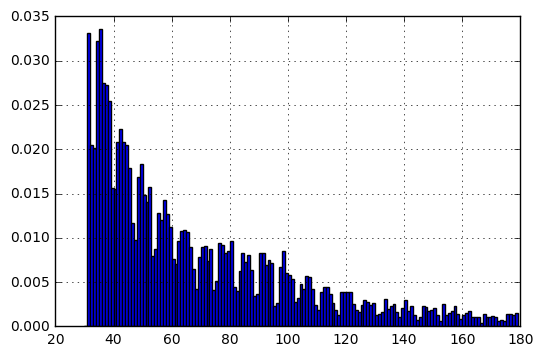

In [29]:
# distribution of tsla *given* tsla > 30
# Note: clipped at 180
# Note: seasonality corresponds to weekday and weekend effect
tsla_30_pd.tsla.hist(bins=range(T0, 180, 1), normed=1)

## 0 < tuna < 90 <=> next time user was active was up to 90 days after D0
(This is killing the kernel for some reason. But it should work)

In [ ]:
# tuna > 0 <=> next time user was active after D0
tuna_90 = mapped.filter(lambda row: (row[4] > 0 and row[4] <= T1))
tuna_90_DF = tuna_90.toDF(["cid","ssd","num_ssd","tsla","tuna"])
tuna_90_pd = tuna_90_DF.toPandas()

In [ ]:
tuna_pos_cnt = tuna_pos.count()*100
print "{:,} users have 0 < tuna < 90 ({:.2%} of DAU)"\
      .format(tuna_pos_cnt, tuna_pos_cnt*1./dau)

In [ ]:
# tuna_pos_pd

In [ ]:
90# distribution of tuna *given* tuna > 0 (they come back)
# Note: clipped at 180
# Note: seasonality corresponds to weekday and weekend effect
tuna_90_pd.tuna.hist(bins=range(0, T1, 1), normed=1)